In [1]:
# ==========================================
# 🔹 1. CARGA DE LIBRERÍAS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 🔹 2. CARGA DE DATASET Y SCHEMA
# ==========================================
schema = pd.read_csv("data/raw/survey_results_schema.csv")
df = pd.read_csv("data/raw/survey_results_public.csv")

print("Filas:", df.shape[0], " Columnas:", df.shape[1])
print("\nPrimeras columnas:\n", df.columns.tolist()[:15])

def map_ai_usage(value):
    if pd.isna(value):
        return np.nan
    v = str(value).lower()
    if v.startswith("yes"):
        return 1
    elif v.startswith("no"):
        return 0
    else:
        return np.nan

df["AI_Usage"] = df["AISelect"].apply(map_ai_usage)
df["AI_Usage"].value_counts(dropna=False)



Filas: 49123  Columnas: 170

Primeras columnas:
 ['ResponseId', 'MainBranch', 'Age', 'EdLevel', 'Employment', 'EmploymentAddl', 'WorkExp', 'LearnCodeChoose', 'LearnCode', 'LearnCodeAI', 'AILearnHow', 'YearsCode', 'DevType', 'OrgSize', 'ICorPM']


AI_Usage
1.0    26438
NaN    15437
0.0     7248
Name: count, dtype: int64

In [4]:
# Seleccionar columnas
cols = [
    "DevType", "WorkExp", "LanguageHaveWorkedWith", "Country",
    "RemoteWork", "Industry", "OrgSize", "EdLevel", "AI_Usage"
]
df = df[cols]
df.head()

,DevType,WorkExp,LanguageHaveWorkedWith,Country,RemoteWork,Industry,OrgSize,EdLevel,AI_Usage
0,"Developer, mobile",8.0,Bash/Shell (all shells);Dart;SQL,Ukraine,Remote,Fintech,20 to 99 employees,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",1.0
1,"Developer, back-end",2.0,Java,Netherlands,"Hybrid (some in-person, leans heavy to flexibi...",Retail and Consumer Services,500 to 999 employees,"Associate degree (A.A., A.S., etc.)",1.0
2,"Developer, front-end",10.0,Dart;HTML/CSS;JavaScript;TypeScript,Ukraine,NaN,Software Development,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1.0
3,"Developer, back-end",4.0,Java;Kotlin;SQL,Ukraine,Remote,Retail and Consumer Services,"10,000 or more employees","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1.0
4,Engineering manager,21.0,C;C#;C++;Delphi;HTML/CSS;Java;JavaScript;Lua;P...,Ukraine,NaN,Software Development,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",1.0


# Revisamos nulos

In [5]:
!pip install missingno


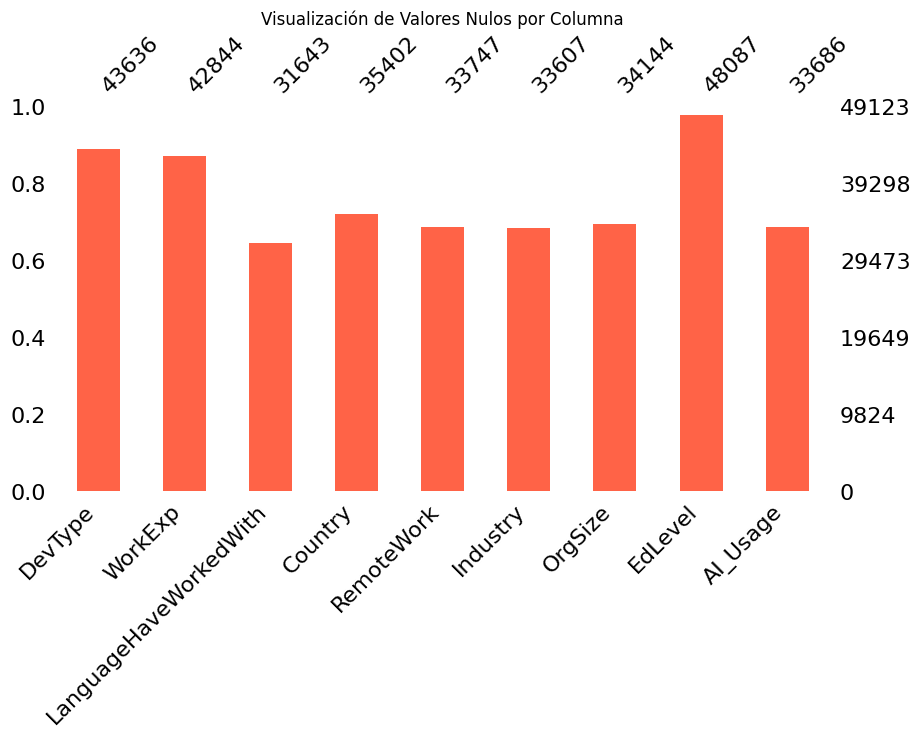

In [9]:
import missingno as msno
import matplotlib.pyplot as plt

# Subconjunto de columnas que te interesan
cols = [
    "DevType", "WorkExp", "LanguageHaveWorkedWith", "Country",
    "RemoteWork", "Industry", "OrgSize", "EdLevel", "AI_Usage"
]
df_subset = df[cols]

# Visualización tipo barra
msno.bar(df_subset, figsize=(10, 5), color="tomato")
plt.title("Visualización de Valores Nulos por Columna")
plt.show()


<Axes: >

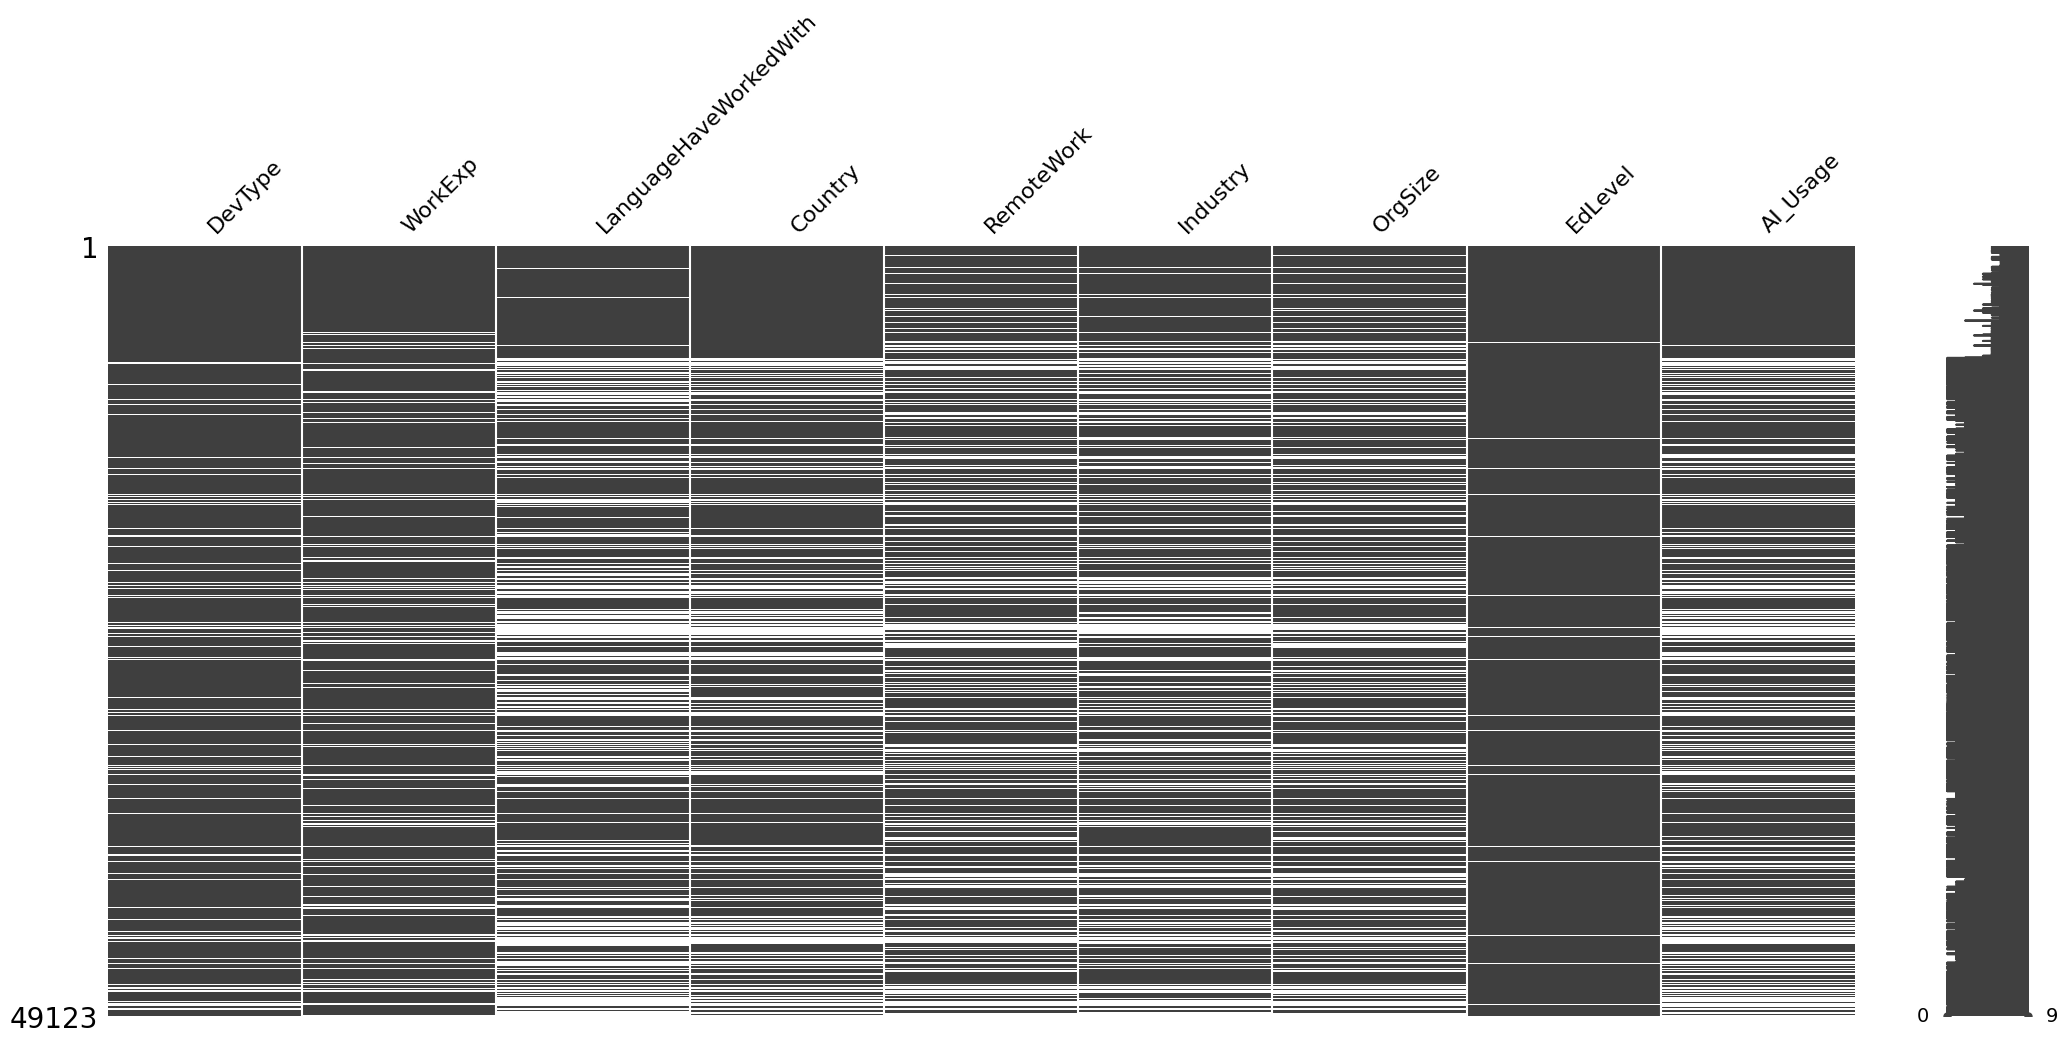

In [11]:
msno.matrix(df_subset)

In [12]:
df_clean = df_subset.dropna()
print(df_clean.shape)

(23821, 9)


In [13]:
# Filtrar solo filas con valor en LearnCodeAI (es decir, los que respondieron sobre uso de IA)
df_ai = df[df["AI_Usage"].notnull()].copy()

# Mostrar tamaño y porcentaje de retención
original_len = len(df)
filtered_len = len(df_ai)
print(f"Filas retenidas: {filtered_len}/{original_len} ({filtered_len/original_len*100:.2f}%)")


Filas retenidas: 33686/49123 (68.57%)


<Axes: >

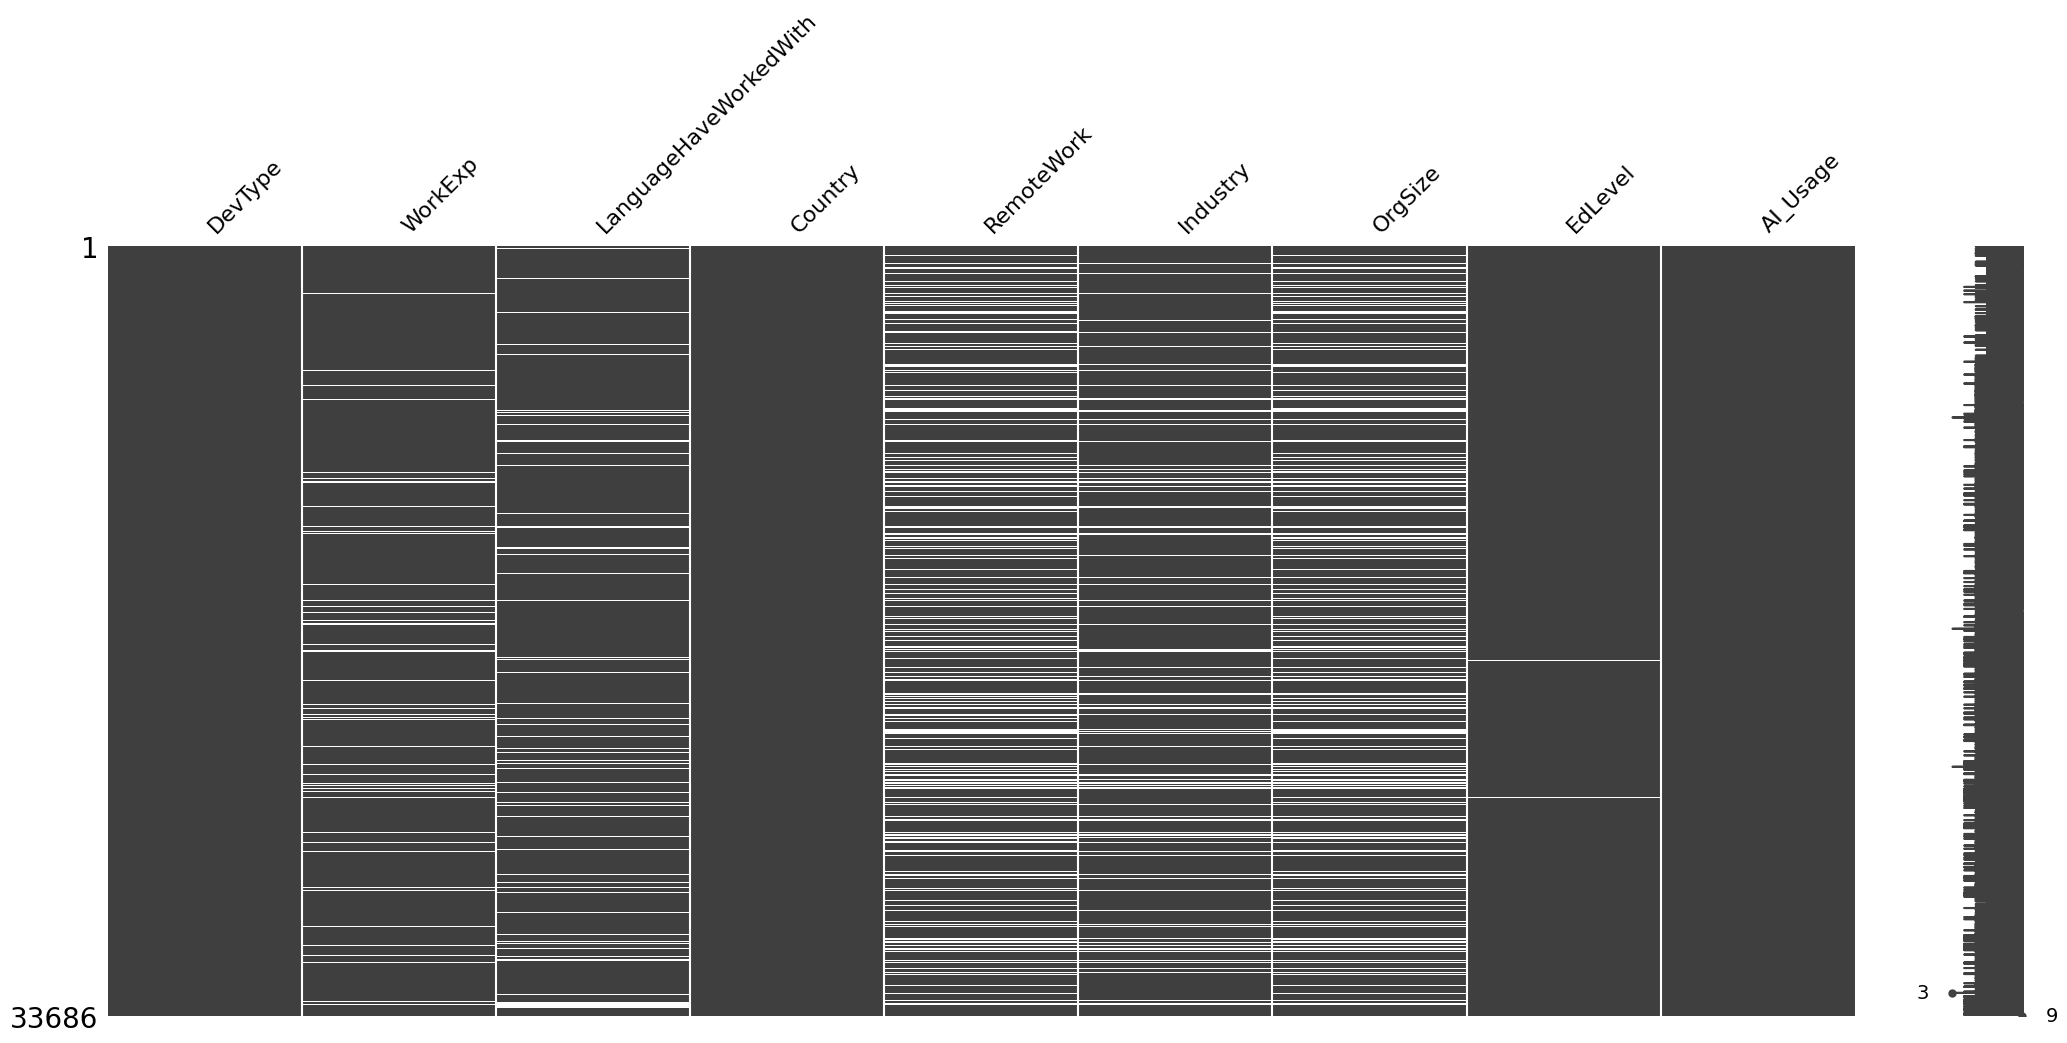

In [16]:
msno.matrix(df_ai)

In [20]:
df_ai["AI_Usage"] = df_ai["AI_Usage"].astype("Int64")
df_ai['AI_Usage'].value_counts()

AI_Usage
1    26438
0     7248
Name: count, dtype: Int64

In [21]:
df_ai["AI_Usage"].dtype

Int64Dtype()

# Limpieza

In [22]:
# Copiamos el dataset filtrado
df_ai_clean = df_ai.copy()

# Rellenar numéricos
df_ai_clean["WorkExp"].fillna(df_ai_clean["WorkExp"].median(), inplace=True)

# Rellenar categóricos con texto genérico
cols_cat = [
    "DevType", "LanguageHaveWorkedWith", "Country",
    "RemoteWork", "Industry", "OrgSize", "EdLevel"
]

for col in cols_cat:
    df_ai_clean[col].fillna("No especificado", inplace=True)

# Verificamos nuevamente los nulos
print(df_ai_clean.isnull().sum())


DevType                   0
WorkExp                   0
LanguageHaveWorkedWith    0
Country                   0
RemoteWork                0
Industry                  0
OrgSize                   0
EdLevel                   0
AI_Usage                  0
dtype: int64


/tmp/ipykernel_11171/1366195586.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ai_clean["WorkExp"].fillna(df_ai_clean["WorkExp"].median(), inplace=True)
/tmp/ipykernel_11171/1366195586.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

# Creo nuevo campo NumLanguages

In [23]:
df_ai_clean["NumLanguages"] = df_ai_clean["LanguageHaveWorkedWith"].apply(
    lambda x: len(str(x).split(";")) if pd.notnull(x) else 0
)

In [24]:
df_ai_clean.head()

,DevType,WorkExp,LanguageHaveWorkedWith,Country,RemoteWork,Industry,OrgSize,EdLevel,AI_Usage,NumLanguages
0,"Developer, mobile",8.0,Bash/Shell (all shells);Dart;SQL,Ukraine,Remote,Fintech,20 to 99 employees,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",1,3
1,"Developer, back-end",2.0,Java,Netherlands,"Hybrid (some in-person, leans heavy to flexibi...",Retail and Consumer Services,500 to 999 employees,"Associate degree (A.A., A.S., etc.)",1,1
2,"Developer, front-end",10.0,Dart;HTML/CSS;JavaScript;TypeScript,Ukraine,No especificado,Software Development,No especificado,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1,4
3,"Developer, back-end",4.0,Java;Kotlin;SQL,Ukraine,Remote,Retail and Consumer Services,"10,000 or more employees","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1,3
4,Engineering manager,21.0,C;C#;C++;Delphi;HTML/CSS;Java;JavaScript;Lua;P...,Ukraine,No especificado,Software Development,No especificado,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",1,14


In [30]:
df_ai_clean.describe()

,WorkExp,AI_Usage,NumLanguages
count,33686.000000,33686.0,33686.000000
mean,13.804429,0.784836,5.708039
std,10.477882,0.410942,3.577649
min,1.000000,0.0,1.000000
25%,6.000000,1.0,3.000000
50%,11.000000,1.0,5.000000
75%,20.000000,1.0,7.000000
max,100.000000,1.0,42.000000


In [31]:
# Seleccionamos las columnas que no son numéricas
cat_cols = [
    "DevType", "Country", "RemoteWork", "Industry", "OrgSize", "EdLevel"
]

# Recorremos e imprimimos valores únicos y conteo
for col in cat_cols:
    print(f"\n📊 Columna: {col}")
    print(f"Valores únicos: {df_ai_clean[col].nunique()}")
    print(df_ai_clean[col].value_counts().head(10))  # Muestra los 10 más comunes



📊 Columna: DevType
Valores únicos: 32
DevType
Developer, full-stack                            9546
Developer, back-end                              4929
Student                                          2263
Architect, software or solutions                 2148
Developer, desktop or enterprise applications    1553
Developer, front-end                             1482
Other (please specify):                          1377
Developer, mobile                                1043
Developer, embedded applications or devices      1015
Academic researcher                               871
Name: count, dtype: int64

📊 Columna: Country
Valores únicos: 176
Country
United States of America                                6931
Germany                                                 2929
India                                                   2269
United Kingdom of Great Britain and Northern Ireland    1964
France                                                  1357
Canada                            

In [34]:
# Columnas categóricas que queremos convertir
cat_cols = [
    "DevType", "Country", "RemoteWork", "Industry", "OrgSize", "EdLevel"
]

# Convertir a tipo category
for col in cat_cols:
    df_ai_clean[col] = df_ai_clean[col].astype("category")

# Verificamos el resultado
df_ai_clean.dtypes[cat_cols]

df_ai_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33686 entries, 0 to 49121
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   DevType                 33686 non-null  category
 1   WorkExp                 33686 non-null  float64 
 2   LanguageHaveWorkedWith  33686 non-null  object  
 3   Country                 33686 non-null  category
 4   RemoteWork              33686 non-null  category
 5   Industry                33686 non-null  category
 6   OrgSize                 33686 non-null  category
 7   EdLevel                 33686 non-null  category
 8   AI_Usage                33686 non-null  Int64   
 9   NumLanguages            33686 non-null  int64   
dtypes: Int64(1), category(6), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [35]:
df_ai_clean.to_csv("data/processed/survey_ai_usage_clean.csv", index=False)

In [37]:
df_ai_clean = pd.read_csv("data/processed/survey_ai_usage_clean.csv")
df_ai_clean.head()

,DevType,WorkExp,LanguageHaveWorkedWith,Country,RemoteWork,Industry,OrgSize,EdLevel,AI_Usage,NumLanguages
0,"Developer, mobile",8.0,Bash/Shell (all shells);Dart;SQL,Ukraine,Remote,Fintech,20 to 99 employees,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",1,3
1,"Developer, back-end",2.0,Java,Netherlands,"Hybrid (some in-person, leans heavy to flexibi...",Retail and Consumer Services,500 to 999 employees,"Associate degree (A.A., A.S., etc.)",1,1
2,"Developer, front-end",10.0,Dart;HTML/CSS;JavaScript;TypeScript,Ukraine,No especificado,Software Development,No especificado,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1,4
3,"Developer, back-end",4.0,Java;Kotlin;SQL,Ukraine,Remote,Retail and Consumer Services,"10,000 or more employees","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1,3
4,Engineering manager,21.0,C;C#;C++;Delphi;HTML/CSS;Java;JavaScript;Lua;P...,Ukraine,No especificado,Software Development,No especificado,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",1,14


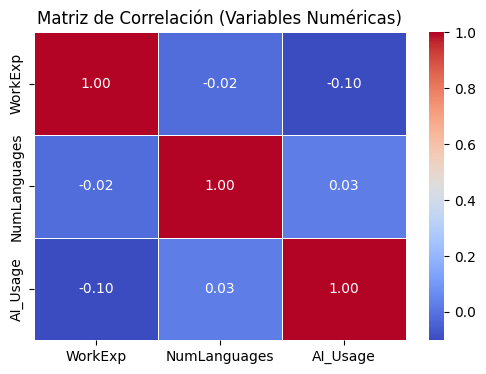

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_ai_clean[["WorkExp", "NumLanguages", "AI_Usage"]].corr(method="spearman")

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación (Variables Numéricas)")
plt.show()


/tmp/ipykernel_11171/3773588160.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ai_clean, x="AI_Usage", y="WorkExp", palette="pastel")


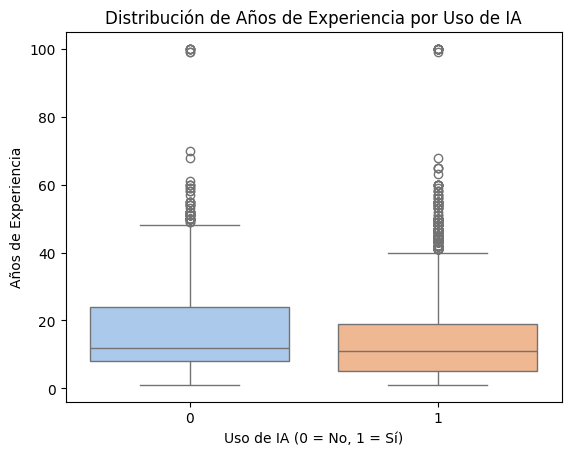

In [42]:
sns.boxplot(data=df_ai_clean, x="AI_Usage", y="WorkExp", palette="pastel")
plt.title("Distribución de Años de Experiencia por Uso de IA")
plt.xlabel("Uso de IA (0 = No, 1 = Sí)")
plt.ylabel("Años de Experiencia")
plt.show()


In [59]:
df_ai_clean_filtered = df_ai_clean.query("WorkExp >= 1 and WorkExp <= 40").copy()
df_ai_clean_filtered.describe()
df_ai_clean_filtered.to_csv("data/processed/survey_ai_usage_clean_filtered.csv", index=False)

/tmp/ipykernel_11171/631221843.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




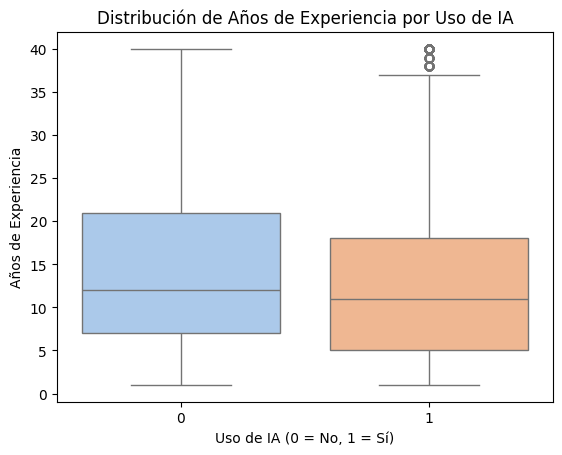

In [57]:
sns.boxplot(data=df_ai_clean_filtered, x="AI_Usage", y="WorkExp", palette="pastel")
plt.title("Distribución de Años de Experiencia por Uso de IA")
plt.xlabel("Uso de IA (0 = No, 1 = Sí)")
plt.ylabel("Años de Experiencia")
plt.show()


In [66]:
import plotly.express as px

fig1_b = px.box(
    df_ai_clean_filtered,
    x="AI_Usage",
    y="WorkExp",
    color="AI_Usage",
    # points="all",  # opcional: muestra puntos individuales
    color_discrete_sequence=["#6EC1E4", "#F87171"],  # tonos más vivos para fondo oscuro
    labels={
        "AI_Usage": "Uso de IA (0 = No, 1 = Sí)",
        "WorkExp": "Años de Experiencia"
    },
    title="Distribución de Años de Experiencia por Uso de IA"
)

fig1_b.update_layout(
    showlegend=False,
    template="plotly_dark",  # 🌙 tema oscuro
    font=dict(size=14, color="white"),  # texto blanco
    title_x=0.5,
    plot_bgcolor="rgba(17,17,17,1)",   # fondo del área de gráficos
    paper_bgcolor="rgba(0,0,0,1)",     # fondo general
    title_font=dict(size=18, color="#E5E5E5")
)

fig1_b.show()

# Exportar versión dark para tu sitio
fig1_b.write_html("docs/assets/charts/chart_1_b.html", include_plotlyjs="cdn")


In [68]:
import plotly.express as px

fig2_b = px.box(
    df_ai_clean_filtered,
    x="AI_Usage",
    y="NumLanguages",
    color="AI_Usage",
    # points="all",  # opcional: muestra puntos individuales
    color_discrete_sequence=["#6EC1E4", "#F87171"],  # azul claro y rojo coral
    labels={
        "AI_Usage": "Uso de IA (0 = No, 1 = Sí)",
        "NumLanguages": "Número de Lenguajes Usados"
    },
    title="Cantidad de Lenguajes por Uso de IA"
)

fig2_b.update_layout(
    showlegend=False,
    template="plotly_dark",  # 🌙 tema oscuro
    font=dict(size=14, color="white"),
    title_x=0.5,
    plot_bgcolor="rgba(17,17,17,1)",   # fondo de la gráfica
    paper_bgcolor="rgba(0,0,0,1)",     # fondo general
    title_font=dict(size=18, color="#E5E5E5")
)

fig2_b.show()

# Guardar versión HTML para Reveal.js o tu dashboard
fig2_b.write_html("docs/assets/charts/chart_2_b.html", include_plotlyjs="cdn")


In [76]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Medias por grupo
mean_no_ai = df_ai_clean_filtered.loc[df_ai_clean_filtered["AI_Usage"] == 0, "NumLanguages"].mean()
mean_ai    = df_ai_clean_filtered.loc[df_ai_clean_filtered["AI_Usage"] == 1, "NumLanguages"].mean()

# Colores
color_no_ai = "#6EC1E4"
color_ai    = "#F87171"

# Subplots: boxplot (arriba) + histograma (abajo)
fig2_hist_box = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.06,
    row_heights=[0.28, 0.72],
    subplot_titles=("Boxplot", "Histograma superpuesto")
)

# --- BOX PLOT (fila 1) en horizontal: usa X para los valores numéricos ---
for val, name, color in [(0, "No usa IA", color_no_ai), (1, "Usa IA", color_ai)]:
    subset = df_ai_clean_filtered[df_ai_clean_filtered["AI_Usage"] == val]["NumLanguages"]
    fig2_hist_box.add_trace(
        go.Box(
            x=subset,               # <--- valores en X (NO en Y)
            name=name,
            marker_color=color,
            boxmean=True,
            orientation="h",
            legendgroup=str(val),
            showlegend=False        # evitamos duplicar leyenda arriba
        ),
        row=1, col=1
    )

# --- HISTOGRAMA (fila 2) ---
for val, name, color in [(0, "No usa IA", color_no_ai), (1, "Usa IA", color_ai)]:
    subset = df_ai_clean_filtered[df_ai_clean_filtered["AI_Usage"] == val]["NumLanguages"]
    fig2_hist_box.add_trace(
        go.Histogram(
            x=subset,
            name=name,
            nbinsx=20,
            opacity=0.6,
            marker_color=color,
            legendgroup=str(val),
            showlegend=True          # mostramos leyenda abajo una sola vez
        ),
        row=2, col=1
    )

# Líneas de media en el histograma
fig2_hist_box.add_vline(x=mean_no_ai, line_color=color_no_ai, line_dash="dash", row=2, col=1)
fig2_hist_box.add_vline(x=mean_ai,    line_color=color_ai,    line_dash="dash", row=2, col=1)

# Layout (dark)
fig2_hist_box.update_layout(
    template="plotly_dark",
    barmode="overlay",
    font=dict(color="white", size=14),
    title=dict(text="Distribución del Número de Lenguajes según Uso de IA", x=0.5, font=dict(size=18, color="#E5E5E5")),
    plot_bgcolor="rgba(17,17,17,1)",
    paper_bgcolor="rgba(0,0,0,1)",
    legend=dict(title="Uso de IA", orientation="h", yanchor="bottom", y=1.05, xanchor="center", x=0.5)
)

# Etiquetas de ejes
fig2_hist_box.update_xaxes(title_text="Número de Lenguajes Usados", row=2, col=1)
fig2_hist_box.update_yaxes(title_text="", row=1, col=1)
fig2_hist_box.update_yaxes(title_text="", row=2, col=1)

fig2_hist_box.show()

# Exporta para tu sitio
fig2_hist_box.write_html("docs/assets/charts/chart_2_b.html", include_plotlyjs="cdn")


In [77]:
country_ai = (
    df_ai_clean_filtered[df_ai_clean_filtered["AI_Usage"].notna()]
    .groupby(["Country", "AI_Usage"])
    .size()
    .reset_index(name="count")
)

fig5_a = px.choropleth(
    country_ai[country_ai["AI_Usage"] == 1],  # solo los que usan IA
    locations="Country",
    locationmode="country names",
    color="count",
    title="Adopción de IA por país (solo usuarios de IA)",
    color_continuous_scale="Tealgrn"
)
fig5_a.update_layout(template="plotly_dark")
fig5_a.show()

fig5_a.write_html("docs/assets/charts/chart_3_b.html", include_plotlyjs="cdn")


/tmp/ipykernel_11171/799160178.py:8: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



In [80]:
import plotly.express as px

# Calcular proporción promedio de uso de IA por tamaño organizacional
org_ai = (
    df_ai_clean_filtered.groupby("OrgSize")["AI_Usage"]
    .mean()
    .sort_values(ascending=True)  # orden ascendente para lectura visual
    .reset_index()
)

# Crear gráfico de barras horizontal
fig6_b = px.bar(
    org_ai,
    x="AI_Usage",
    y="OrgSize",
    orientation="h",
    color="AI_Usage",
    color_continuous_scale="Bluered_r",  # paleta con contraste sobre fondo oscuro
    labels={
        "AI_Usage": "Proporción de Usuarios de IA",
        "OrgSize": "Tamaño Organizacional"
    },
    title="Uso de IA por Tamaño de Empresa"
)

# Personalizar layout en modo oscuro
fig6_b.update_layout(
    template="plotly_dark",
    font=dict(color="white"),
    title_x=0.5,
    plot_bgcolor="rgba(17,17,17,1)",
    paper_bgcolor="rgba(0,0,0,1)",
    coloraxis_colorbar=dict(
        title="Proporción de<br>Usuarios de IA",
        tickformat=".2f"
    )
)

fig6_b.show()

# Exportar para Reveal.js o dashboard
fig6_b.write_html("docs/assets/charts/chart_6_b.html", include_plotlyjs="cdn")


In [78]:
import plotly.express as px

industry_ai = (
    df_ai_clean_filtered.groupby("Industry")["AI_Usage"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .head(15)
)

fig4_b = px.bar(
    industry_ai,
    x="AI_Usage",
    y="Industry",
    orientation="h",
    color="AI_Usage",
    color_continuous_scale="Tealrose",
    labels={
        "AI_Usage": "Proporción de Usuarios de IA",
        "Industry": "Industria"
    },
    title="Uso de IA por Industria (Top 15)"
)

fig4_b.update_layout(
    template="plotly_dark",
    font=dict(color="white"),
    title_x=0.5,
    plot_bgcolor="rgba(17,17,17,1)",
    paper_bgcolor="rgba(0,0,0,1)"
)

fig4_b.show()
fig4_b.write_html("docs/assets/charts/chart_4_b.html", include_plotlyjs="cdn")


In [79]:
ed_ai = (
    df_ai_clean_filtered.groupby("EdLevel")["AI_Usage"]
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)

fig5_b = px.bar(
    ed_ai,
    x="AI_Usage",
    y="EdLevel",
    orientation="h",
    color="AI_Usage",
    color_continuous_scale="Viridis",
    labels={
        "AI_Usage": "Proporción de Usuarios de IA",
        "EdLevel": "Nivel Educativo"
    },
    title="Uso de IA por Nivel Educativo"
)

fig5_b.update_layout(
    template="plotly_dark",
    font=dict(color="white"),
    title_x=0.5,
    plot_bgcolor="rgba(17,17,17,1)",
    paper_bgcolor="rgba(0,0,0,1)"
)

fig5_b.show()
fig5_b.write_html("docs/assets/charts/chart_5_b.html", include_plotlyjs="cdn")


In [ ]:

# ==========================================
# 🔹 3. INSPECCIÓN DE LA VARIABLE OBJETIVO
# ==========================================
if "AI_Usage" not in df.columns:
    raise KeyError("No se encontró la columna 'AI_Usage' en el dataset.")

print("\nValores únicos en AI_Usage:", df["AI_Usage"].unique())
print("\nDistribución:")
print(df["AI_Usage"].value_counts(normalize=True))

# Eliminamos filas sin respuesta
df = df.dropna(subset=["AI_Usage"])

# ==========================================
# 🔹 4. SELECCIÓN DE VARIABLES PREDICTORAS
# ==========================================
# Seleccionamos algunas variables representativas del survey
predictors = [
    "Country",
    "EdLevel",                # Nivel educativo
    "DevType",                # Tipo de desarrollador
    "LanguageHaveWorkedWith", # Lenguajes usados
    "Industry",               # Industria
    "OrgSize",                # Tamaño de empresa
    "Age",                    # Edad (si está disponible)
    "Employment",             # Tipo de empleo
]

available_predictors = [col for col in predictors if col in df.columns]
print("\nVariables disponibles:", available_predictors)

X = df[available_predictors]
y = df["AI_Usage"]

# ==========================================
# 🔹 5. LIMPIEZA BÁSICA
# ==========================================
# Convertimos NaN a 'Unknown' para las categóricas
X = X.fillna("Unknown")

# ==========================================
# 🔹 6. DIVISIÓN TRAIN / TEST
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ==========================================
# 🔹 7. PIPELINE DE PREPROCESAMIENTO + MODELO
# ==========================================
cat_cols = X_train.columns  # todas son categóricas en este caso

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# ==========================================
# 🔹 8. ENTRENAMIENTO
# ==========================================
model.fit(X_train, y_train)

# ==========================================
# 🔹 9. EVALUACIÓN
# ==========================================
y_pred = model.predict(X_test)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ==========================================
# 🔹 10. MATRIZ DE CORRELACIÓN (entre variables codificadas)
# ==========================================
# Solo para una vista exploratoria simple (opcional)
# Esto usa las versiones codificadas del conjunto de entrenamiento

X_encoded = pd.DataFrame(
    model.named_steps["preprocessor"].transform(X_train).toarray(),
    columns=model.named_steps["preprocessor"].get_feature_names_out()
)
corr = pd.DataFrame(np.corrcoef(X_encoded.T, y_train), 
                    index=X_encoded.columns.tolist()+["AI_Usage"],
                    columns=X_encoded.columns.tolist()+["AI_Usage"])

# Visualizamos solo las 10 variables con mayor correlación absoluta con AI_Usage
cor_with_ai = corr["AI_Usage"].drop("AI_Usage").abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
cor_with_ai.plot(kind='barh', color='salmon')
plt.title("Variables más correlacionadas con AI_Usage")
plt.xlabel("Correlación (absoluta)")
plt.gca().invert_yaxis()
plt.show()
